# <center> Alpha Airlines </center>

Alpha Airlines ha encargado una nueva flota de DC- 717. En esta fase del contrato, el director de operaciones de Alpha debe especificar la configuración de asientos del avión que se utilizará en el circuito Boston-Atlanta-Chicago-Boston. Alpha vuela en esta ruta una vez al día.

La decisión de configuración implica especificar cuántas filas se asignarán a la primera clase y cuántas a la clase turista. Si el avión estuviera configurado en su totalidad con filas de turista (que contienen seis asientos cada una), habría cuarenta filas. Los asientos de primera clase son más anchos y ofrecen más espacio para las piernas, por lo que, para hacer sitio a una fila de primera clase (que contiene cuatro asientos), hay que eliminar dos filas de turista. Por lo tanto, la conversión de asientos de turista a primera clase implica la pérdida de algunos asientos, pero la conversión puede ser atractiva porque los ingresos son mayores para los pasajeros de primera clase que para los de turista (véase el Cuadro 1).

Rara vez es posible una coincidencia perfecta entre la configuración y la demanda de asientos. Los datos históricos sugieren una distribución probabilística de la demanda de asientos en cada tramo (como se detalla en el Cuadro 2).

Para el tramo Atlanta - Chicago se tienen los siguientes datos históricos de la demanda de asientos (aunque la experiencia ha mostrado que la demanda mínima es de 140 asientos y la demanda máxima es de 240 asientos para este tramo):

Existe otra distribución para la fracción de la demanda que corresponde a los asientos de primera clase (Cuadro 3), que parece aplicarse en todos los tramos, aunque la fracción que se produce en un mercado en cualquier día es independiente de la fracción en los demás mercados. Por último, hay alguna posibilidad de que todos los asientos de cualquiera de las categorías de asientos se reserven en un tramo determinado cuando se produzca la demanda de esa categoría. Con las actuales políticas de gestión, esa demanda se pierde sencillamente en favor de los competidores.

El costo fijo de operar el circuito completo es de 100.000 dólares por día. Alpha Airlines busca una configuración que maximice los beneficios.

## Nota
Por facilidad en el manejo de algoritmos manejaremos la siguiente convención

- **Circuito:** *[Boston-atlanta, atlanta-chicago, chicago-boston]* => En los casos en que cada tramo tiene datos diferentes los diferenciaremos por sus respectivos indices dentro del circuito
- **Tipo asiento:** *[clase-primera, clase-turista]* => En los casos en que se requiera diferencias el tipo de asiento, se diferenciaran por sus respectivos indices dentro del tipo de asiento
- **Distribuciones triangulares:** *[min, max, moda]* => Para trabajar correctamente con la distribucion triangular y la funcion triang de scipy, guardamos en este orden los datos de la distribución

## Modelo de simulación

### 1. Librerias necesarias

In [322]:
from scipy.stats import rv_histogram, rv_discrete, binom, mode, triang
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### 2. Entradas conocidas

In [323]:
# Datos
costo_fijo = 100000
max_filas = 40
cantidad_tramos = 3
circuito = ['boston-atlanta', 'atlanta-chicago', 'chicago-boston']
clase_asiento = ['clase_primera', 'clase_turista']

# Ingresos por asiento segun el tramo [clase_primera, clase_turista]
ingresos_asientos = [list([400, 175]), list([400, 150]), list([450, 200])]

# Cantidad asientos [clase_primera, clase_turista]
num_asientos = [4, 6]

In [324]:
# Tramo Atlanta-Chicago
tramo_atlanta_chicago = list([173,212,225,199,205,176,215,198,198,184,199,211,233,195,217,209,177,161,175,209,197,206,167,196,205,219,184,172,207,191,164,216,163,236,183,213,195,182,238,141,178,211,165,213,186,202,186,194,210,206,196,197,236,173,199,211,168,181,206,216,196,201,180,209,176,221,190,206,190,210])

moda_tramo_atlanta_chicago = mode(tramo_atlanta_chicago, axis=None, keepdims=True)[0].item()

# Crear el histograma
hist_atlanta_chicago = np.histogram(tramo_atlanta_chicago, bins="sturges", density=True)

# Ajustar el histograma a una distribución
hist_dist_atlanta_chicago = rv_histogram(hist_atlanta_chicago)
print('\tEstadistica Tramo Atlanta-Chicago')
print('Moda:', moda_tramo_atlanta_chicago)
print('Probabilidad acumulada:', hist_dist_atlanta_chicago.cdf(200))
print('Media:', hist_dist_atlanta_chicago.mean())
print('Desviación estándar:', hist_dist_atlanta_chicago.std())
print('Densidad de probabilidad (8.0):', hist_dist_atlanta_chicago.pdf(8.0))
print('Densidad de probabilidad (0.5):', hist_dist_atlanta_chicago.pdf(0.5))
print('Media, varianza, asimetría y curtosis:', hist_dist_atlanta_chicago.stats(moments='mvsk'))
print('Varianza:', hist_dist_atlanta_chicago.stats(moments='s'))
print('Media (momento 1):', hist_dist_atlanta_chicago.moment(1))
print('Support:', hist_dist_atlanta_chicago.support())

	Estadistica Tramo Atlanta-Chicago
Moda: 206
Probabilidad acumulada: 0.538880706921944
Media: 195.9089285714286
Desviación estándar: 19.752758488364364
Densidad de probabilidad (8.0): 0.0
Densidad de probabilidad (0.5): 0.0
Media, varianza, asimetría y curtosis: (np.float64(195.9089285714286), np.float64(390.17146789965045), np.float64(-0.28226074552330727), np.float64(-0.3881871969656636))
Varianza: -0.28226074552330727
Media (momento 1): 195.9089285714286
Support: (np.float64(141.0), np.float64(238.0))


In [325]:
# Ditribuciones de la demanda segun el tramo - [min, max, moda]
distribuciones_demandas = list([list([160, 220, 180]), list([140, 240, moda_tramo_atlanta_chicago]), list([150, 225, 200])])

# Distribución de la fracción de clase primera
fraccion_demanda_clase_primera = list([0.05, 0.12, 0.15])
prob_demanda_clase_primera = list([0.2, 0.5, 0.3])

### 3. Variables de decisión

In [342]:
filas_configurar_clase_primera = list(range(3, 8))

### 4. Entradas inciertas

In [327]:
# def get_random_triangular (array):
#   return random.triangular(array[0], array[2], array[1])

def get_random_triangular(array):
  a, b, c = array  # Mínimo, Máximo, Moda
  c_scaled = (c - a) / (b - a)  # Convertir moda a la escala de scipy
  return triang.rvs(c_scaled, loc=a, scale=(b - a))

In [328]:
fraccion_clase_primera = rv_discrete(name='Fraccion clase primera', values=(fraccion_demanda_clase_primera, prob_demanda_clase_primera))

### 5. Cálculos intermedios

In [329]:
trials = 20000
resultados = []
beneficios = []

for filas_clase_primera in filas_configurar_clase_primera:
  beneficio = []
  filas_clase_turista = max_filas - (2 * filas_clase_primera)

  asientos_disponibles_clase_primera = filas_clase_primera * num_asientos[0]
  asientos_disponibles_clase_turista = filas_clase_turista * num_asientos[1]

  for _ in range(trials):
    demanda_total_tramo = [math.ceil(get_random_triangular(distribuciones_demandas[i])) for i in range(cantidad_tramos)]

    fraccion_demanda_clase_primera_tramo = [fraccion_clase_primera.rvs() for _ in range(cantidad_tramos)]

    demanda_clase_primera_tramo = [binom.rvs(demanda_total_tramo[i], fraccion_demanda_clase_primera_tramo[i]) for i in range(cantidad_tramos)]
    demanda_clase_turista_tramo = [(demanda_total_tramo[i] - demanda_clase_primera_tramo[i]) for i in range(cantidad_tramos)]

    asientos_vendidos_clase_primera = [min(demanda_clase_primera_tramo[i], asientos_disponibles_clase_primera) for i in range(cantidad_tramos)]
    asientos_vendidos_clase_turista = [min(demanda_clase_turista_tramo[i], asientos_disponibles_clase_turista) for i in range(cantidad_tramos)]

    ingresos_clase_primera = [asientos_vendidos_clase_primera[i] * ingresos_asientos[i][0] for i in range(cantidad_tramos)]
    ingresos_clase_turista = [asientos_vendidos_clase_turista[i] * ingresos_asientos[i][1] for i in range(cantidad_tramos)]
    ingresos_totales = sum(ingresos_clase_primera) + sum(ingresos_clase_turista)

    beneficio.append(ingresos_totales - costo_fijo)

  beneficios.append(beneficio)
  resultados.append({
    'Filas primera clase': filas_clase_primera,
    'Filas clase turista': filas_clase_turista,
    'Minimo': np.min(beneficio),
    'Percentil 20': np.percentile(beneficio, 20),
    'Media': np.mean(beneficio),
    'Percentil 80': np.percentile(beneficio, 80),
    'Maximo': np.max(beneficio),
  })

### 6. Salidas

#### Para solo 1 configuración de filas

In [339]:
beneficio_seleccionado = beneficios[0]

##### Graficas

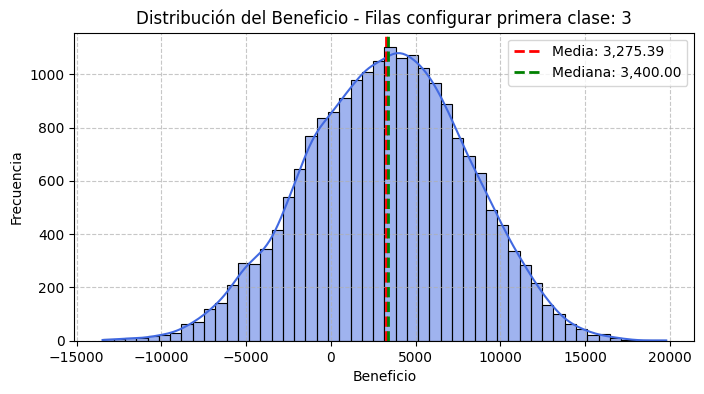

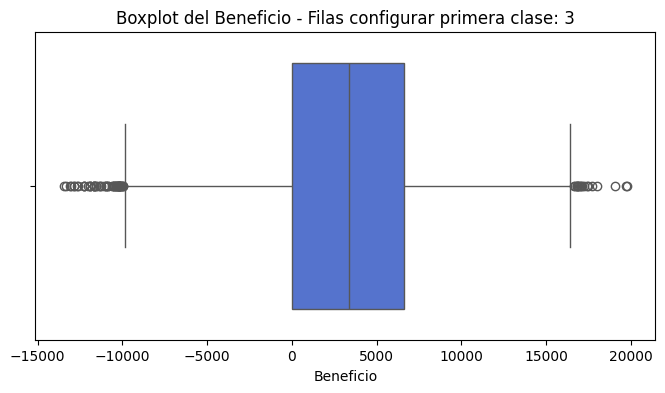

In [341]:
# Convertir a DataFrame
df_beneficio = pd.DataFrame(beneficio_seleccionado, columns=["Beneficio"])

# Graficar histograma con KDE
plt.figure(figsize=(8, 4))
sns.histplot(df_beneficio["Beneficio"], bins=50, kde=True, color="royalblue")
plt.axvline(df_beneficio["Beneficio"].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Media: {df_beneficio["Beneficio"].mean():,.2f}')
plt.axvline(df_beneficio["Beneficio"].median(), color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {df_beneficio["Beneficio"].median():,.2f}')
plt.legend()
plt.title(f"Distribución del Beneficio - Filas configurar primera clase: {filas_configurar_clase_primera[0]}")
plt.xlabel("Beneficio")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Boxplot para ver valores atípicos
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_beneficio["Beneficio"], color="royalblue")
plt.title(f"Boxplot del Beneficio - Filas configurar primera clase: {filas_configurar_clase_primera[0]}")
plt.show()

##### Analisis

In [332]:
# Umbral de equilibrio
umbral_equilibrio = 0

# Proporción de días en equilibrio
dias_en_equilibrio = sum(np.array(beneficio_seleccionado) >= umbral_equilibrio)
proporcion_equilibrio = dias_en_equilibrio / len(beneficio_seleccionado)

print(f"Proporción de días en equilibrio: {proporcion_equilibrio:.2%} ({dias_en_equilibrio}/{len(beneficio_seleccionado)} días)")

Proporción de días en equilibrio: 75.12% (15024/20000 días)


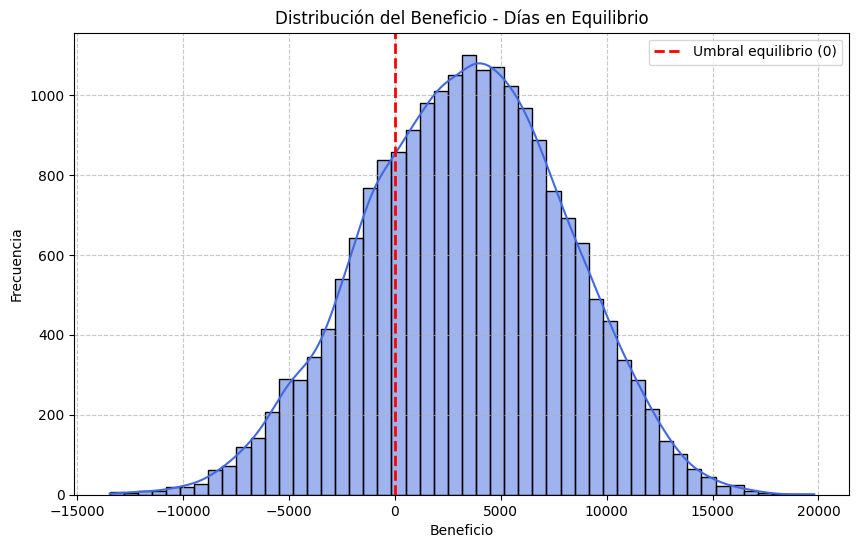

In [333]:
plt.figure(figsize=(10, 6))
sns.histplot(beneficio_seleccionado, bins=50, kde=True, color="royalblue")
plt.axvline(umbral_equilibrio, color='red', linestyle='dashed', linewidth=2, label=f'Umbral equilibrio ({umbral_equilibrio})')
plt.legend()
plt.title("Distribución del Beneficio - Días en Equilibrio")
plt.xlabel("Beneficio")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

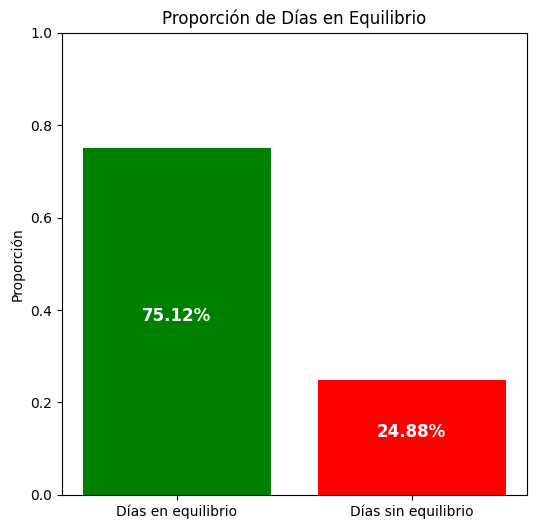

In [334]:
# Datos
labels = ["Días en equilibrio", "Días sin equilibrio"]
valores = [proporcion_equilibrio, 1 - proporcion_equilibrio]

# Gráfico de barras
plt.figure(figsize=(6, 6))
plt.bar(labels, valores, color=["green", "red"])
plt.ylim(0, 1)
plt.ylabel("Proporción")
plt.title("Proporción de Días en Equilibrio")
plt.text(0, valores[0] / 2, f"{valores[0]:.2%}", ha='center', fontsize=12, color="white", fontweight="bold")
plt.text(1, valores[1] / 2, f"{valores[1]:.2%}", ha='center', fontsize=12, color="white", fontweight="bold")
plt.show()

#### Segun varias configuraciones de filas

In [335]:
# Crear un DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

# Mostrar los resultados
print(df_resultados)

   Filas primera clase  Filas clase turista  Minimo  Percentil 20       Media  \
0                    3                   34  -13475        -825.0  3275.38750   
1                    4                   32   -8900        3150.0  6908.65625   
2                    5                   30   -9375        5725.0  9396.88500   
3                    6                   28   -9400        5800.0  9650.01500   
4                    7                   26  -12800        2900.0  7218.20000   

   Percentil 80  Maximo  
0        7375.0   19800  
1       10800.0   20800  
2       13175.0   19500  
3       13725.0   18200  
4       11775.0   16900  


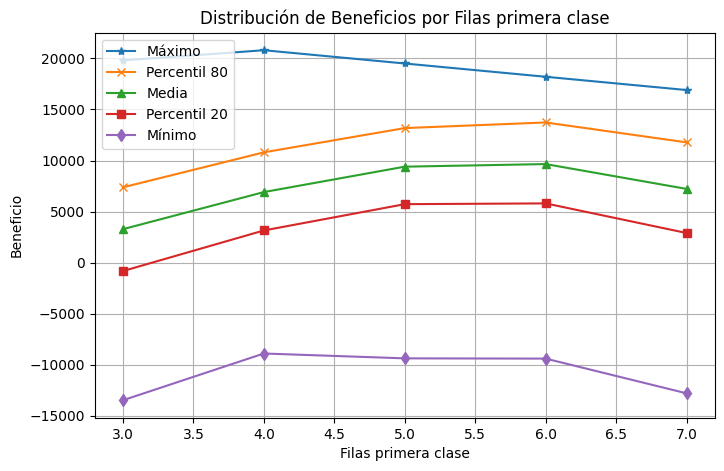

In [336]:
# Crear el gráfico
plt.figure(figsize=(8, 5))

# Graficar cada métrica con diferentes estilos
plt.plot(df_resultados["Filas primera clase"], df_resultados["Maximo"], marker='*', linestyle='-', label="Máximo")
plt.plot(df_resultados["Filas primera clase"], df_resultados["Percentil 80"], marker='x', linestyle='-', label="Percentil 80")
plt.plot(df_resultados["Filas primera clase"], df_resultados["Media"], marker='^', linestyle='-', label="Media")
plt.plot(df_resultados["Filas primera clase"], df_resultados["Percentil 20"], marker='s', linestyle='-', label="Percentil 20")
plt.plot(df_resultados["Filas primera clase"], df_resultados["Minimo"], marker='d', linestyle='-', label="Mínimo")

# Etiquetas y título
plt.xlabel("Filas primera clase")
plt.ylabel("Beneficio")
plt.title("Distribución de Beneficios por Filas primera clase")
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()

In [337]:
def elegir_mejor_configuracion(df):
    """
    Determina la mejor configuración de filas en primera clase basado en media, percentiles y riesgo.
    """
    # Normalizar los valores (escalar entre 0 y 1)
    df_norm = df.copy()
    for col in ["Minimo", "Percentil 20", "Media", "Percentil 80", "Maximo"]:
        df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    # Ponderaciones
    pesos = {
        "Media": 0.4,          # Beneficio esperado (mayor peso)
        "Percentil 20": 0.25,  # Protección en los peores casos
        "Minimo": 0.15,        # Evitar grandes pérdidas
        "Percentil 80": 0.15,  # Oportunidad de buenos resultados
        "Maximo": 0.05         # Potencial de ganancia máxima
    }

    # Calcular el puntaje final para cada configuración
    df_norm["Puntaje"] = sum(df_norm[col] * peso for col, peso in pesos.items())

    # Obtener la mejor configuración
    mejor_config = df.loc[df_norm["Puntaje"].idxmax()]

    return mejor_config, df_norm

In [338]:
# Elegir la mejor configuración
mejor_configuracion, df_puntajes = elegir_mejor_configuracion(df_resultados)

print("\n🏆 Mejor Configuración de Filas:")
print(mejor_configuracion)


🏆 Mejor Configuración de Filas:
Filas primera clase        6.000
Filas clase turista       28.000
Minimo                 -9400.000
Percentil 20            5800.000
Media                   9650.015
Percentil 80           13725.000
Maximo                 18200.000
Name: 3, dtype: float64
